In [1]:
#from scipy.sparse.linalg import spsolve
#from scipy.sparse import csc_matrix
#import scipy.sparse as sparse
import scipy.linalg as linalg
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import mylib
from scipy import stats

$[D - \mathbb{C}\mathbb{A}^{-1}B]\mathbf{v}^{k+1} = (\mathbb{C}-C)\mathbf{u}^k -\mathbb{C}\mathbb{A}^{-1}[\mathbf{f}_1 + (\mathbb{A}-A)\mathbf{u}^k] + \mathbf{f}_2$

$A\mathbf{u}^{k+1}=-B\mathbf{v}^{k+1}$

condition number of A = 178.06427461086045
condition number of B = 178.06427461086028
condition number of C = 178.06427461086028
condition number of D = 11.852695909500618
condition number of Z = 315.01531877110506

monolithic error = 3.2488585951643967e-14


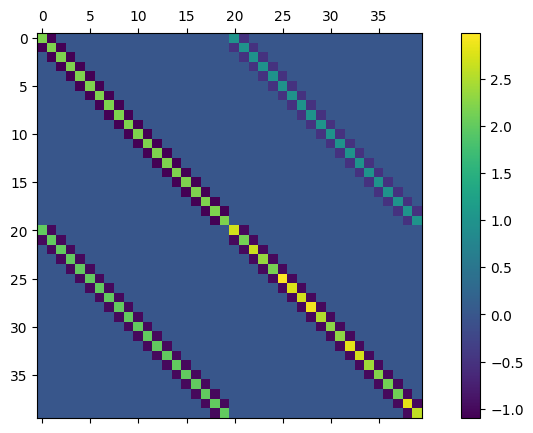

TypeError: method_BlockJacobi() takes 8 positional arguments but 9 were given

<Figure size 600x500 with 0 Axes>

In [2]:
def generate_fd1D_laplacian(size, w):
    return w*(np.diag(-1*np.ones(size-1),-1) + np.diag(2*np.ones(size),0) + np.diag(-1*np.ones(size-1),1))

def generate_diag(size, w):
    return np.diag(w*np.ones(size),0)

def generate_matrices(wA, wB, wC, wD):
    A = generate_fd1D_laplacian(size, wA)
    #A = generate_diag(size, wA)

    B = generate_fd1D_laplacian(size, wB)
    #B = generate_diag(size, wB)

    C = generate_fd1D_laplacian(size, wC)
    #C = generate_diag(size, wC)

    D = generate_fd1D_laplacian(size, wD) + np.diag(np.random.rand(size),0)
    #D = generate_diag(size, wD)

    Z = np.zeros((2*size,2*size))
    Z[:size,:size] = A
    Z[:size,size:] = B
    Z[size:,:size] = C
    Z[size:,size:] = D
    #print("determinant of A =", linalg.det(A))
    print("condition number of A =", np.linalg.cond(A))
    #print("determinant of B =", linalg.det(B))
    print("condition number of B =", np.linalg.cond(B))
    #print("determinant of C =", linalg.det(C))
    print("condition number of C =", np.linalg.cond(C))
    #print("determinant of D =", linalg.det(D))
    print("condition number of D =", np.linalg.cond(D))
    #print("determinant of Z =", linalg.det(Z))
    print("condition number of Z =", np.linalg.cond(Z))
    return A, B, C, D, Z

size = 20
A, B, C, D, Z = generate_matrices(wA=1.1, wB=0.5, wC=1, wD=1)
f1 = np.random.rand(size)
f2 = np.random.rand(size)
f = np.concatenate((f1,f2))
sol = linalg.solve(Z, f)
print()
print(f"monolithic error = {np.linalg.norm(f-np.dot(Z,sol))}")
fig1, ax = plt.subplots(1, 1, figsize=(10,5))
cax = ax.matshow(Z)
fig1.colorbar(cax, ax=ax)
plt.savefig('matrix.pdf')
plt.show()

nit = 20
Lvec = [0.4, 0.5]
clrs = ['r', 'b', 'g']

plt.figure(dpi=100, figsize=(6,5))

omega = 1.0
u_BJ,   v_BJ,   res_BJ   = mylib.method_BlockJacobi(A, B, C, D, f1, f2, nit, 0, sol)
#u_BSOR, v_BSOR, res_BSOR = mylib.method_BlockSOR(A, B, C, D, f1, f2, nit, omega, sol)
#u_BGS,  v_BGS,  res_BGS  = mylib.method_BlockGaussSeidel(A, B, C, D, f1, f2, nit, 0, sol)
#u_SPJ,  v_SPJ,  res_SPJ  = mylib.method_ShurPartialJacobi(A, B, C, D, f1, f2, nit, 0, sol)
#u_SPJ2, v_SPJ2, res_SPJ2 = mylib.method_ShurDualPartialJacobi(A, B, C, D, f1, f2, nit, sol)
u_BSOR, v_BSOR, res_BSOR = mylib.method_BlockSOR(A, B, A-C, B-D, f1, f1-f2, nit, omega, sol)
u_BGS,  v_BGS,  res_BGS  = mylib.method_BlockGaussSeidel(A, B, A-C, B-D, f1, f1-f2, nit, 0, sol)
u_SPJ,  v_SPJ,  res_SPJ  = mylib.method_ShurPartialJacobi(A, B, A-C, B-D, f1, f1-f2, nit, 0, sol)
u_SPJ2, v_SPJ2, res_SPJ2 = mylib.method_ShurDualPartialJacobi(A, B, A-C, B-D, f1, f1-f2, nit, sol)

nn = 5
l1 = slope(res_BSOR[:nn])
l2 = slope(res_BGS[:nn])
l3 = slope(res_SPJ[:nn])
l4 = slope(res_BJ[:nn])
l5 = slope(res_SPJ2[:nn])

plt.semilogy(res_BJ,  'c.-',  label=f"Block-Jacobi               slope={np.round(-l4,3)}")
plt.semilogy(res_BSOR, 'r*-', label=f"Block-SOR                  slope={np.round(-l1,3)}   omega={omega}")
plt.semilogy(res_BGS, 'b.-',  label=f"Block-Gauss-Seidel         slope={np.round(-l2,3)}   ")
plt.semilogy(res_SPJ, 'g.-',  label=f"SPJ     slope={np.round(-l3,3)}")
plt.semilogy(res_SPJ2,'k.-',  label=f"S2PJ   slope={np.round(-l5,3)}")

plt.grid()
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.32), ncol=1, fancybox=True, shadow=True)
plt.legend()
#plt.ylim(top=2000)
plt.savefig('conv.pdf')
plt.xlabel('iterations')
plt.ylabel('error')
plt.show()